In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [ ]:
tickers = ['AAPL', 'AMZN', 'JPM', 'PG', 'JNJ']
data = yf.download(tickers, period="3y")['Close']

daily_rets = data.pct_change().dropna()

mu = daily_rets.mean().values * 252
Sigma = daily_rets.cov().values * 252
n = len(tickers)

/tmp/ipython-input-2663469446.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period="3y")['Close']
[*********************100%***********************]  5 of 5 completed


In [ ]:
gamma_values = np.logspace(-2, 3, num=40)
frontier_returns = []
frontier_risks = []

w = cp.Variable(n)

for g in gamma_values:
    obj = cp.Maximize(mu @ w - (g/2) * cp.quad_form(w, Sigma))
    constraints = [cp.sum(w) == 1, w >= 0]
    prob = cp.Problem(obj, constraints)
    prob.solve()

    if prob.status == 'optimal':
        frontier_returns.append(mu @ w.value)
        frontier_risks.append(np.sqrt(w.value.T @ Sigma @ w.value))

In [ ]:
w_mvp = cp.Variable(n)
mvp_prob = cp.Problem(cp.Minimize(cp.quad_form(w_mvp, Sigma)),
                      [cp.sum(w_mvp) == 1, w_mvp >= 0])
mvp_prob.solve()

w_equal = np.ones(n) / n
equal_ret = mu @ w_equal
equal_risk = np.sqrt(w_equal.T @ Sigma @ w_equal)

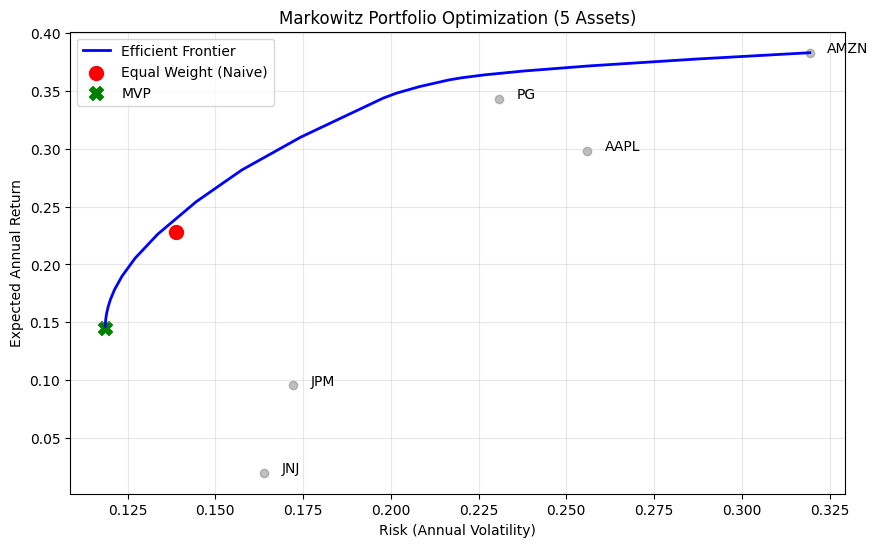

--- OPTIMAL WEIGHTS (MVP) ---
AAPL: 7.20%
AMZN: 9.72%
JPM: 32.86%
PG: 13.83%
JNJ: 36.38%


In [ ]:
plt.figure(figsize=(10,6))
plt.plot(frontier_risks, frontier_returns, label='Efficient Frontier', color='blue', linewidth=2)

plt.scatter(equal_risk, equal_ret, color='red', label='Equal Weight (Naive)', s=100)
plt.scatter(np.sqrt(w_mvp.value.T @ Sigma @ w_mvp.value), (mu @ w_mvp.value),
            color='green', marker='X', s=100, label='MVP')

for i in range(n):
    plt.scatter(np.sqrt(Sigma[i,i]), mu[i], color='gray', alpha=0.5)
    plt.text(np.sqrt(Sigma[i,i]) + 0.005, mu[i], tickers[i])

plt.title('Markowitz Portfolio Optimization (5 Assets)')
plt.xlabel('Risk (Annual Volatility)')
plt.ylabel('Expected Annual Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("--- OPTIMAL WEIGHTS (MVP) ---")
for i in range(n):
    print(f"{tickers[i]}: {w_mvp.value[i]*100:.2f}%")

The Week 2 empirical method uses a guess and check strategy by running manual loops to test every possible weight combination at fixed increments, like 2%. This manual approach creates a cloud of data points, but it is limited by the step size and becomes extremely slow if you add more stocks to the portfolio. The CVXPY method uses a mathematical solver to calculate the exact optimal weights immediately using calculus. This optimization approach is much more precise, handles a large number of assets very quickly, and produces a perfectly smooth Efficient Frontier line that represents the absolute theoretical limit of the portfolio.